In [ ]:
# Importo el repo de github
!git clone https://github.com/Sansote/TT1-Trabajo_Final_2025.git

fatal: destination path 'TT1-Trabajo_Final_2025' already exists and is not an empty directory.


In [ ]:
# instalo esta version de torch que es la que mejor funcion para trabajar el modelado
pip install torch==1.13.1

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Importo el dataset
ruta = 'TT1-Trabajo_Final_2025/salida_acciones_dolarizadas.xlsx'
df = pd.read_excel(ruta, index_col='Date', parse_dates=True)
df.head()

,Close_ALUA.BA,High_ALUA.BA,Low_ALUA.BA,Open_ALUA.BA,Volume_ALUA.BA,Close_BBAR.BA,High_BBAR.BA,Low_BBAR.BA,Open_BBAR.BA,Volume_BBAR.BA,...,Close_METR.BA_usd_ret_usd,Close_PAMP.BA_usd_ret_usd,Close_SUPV.BA_usd_ret_usd,Close_TECO2.BA_usd_ret_usd,Close_TGNO4.BA_usd_ret_usd,Close_TGSU2.BA_usd_ret_usd,Close_TRAN.BA_usd_ret_usd,Close_TXAR.BA_usd_ret_usd,Close_VALO.BA_usd_ret_usd,Close_YPFD.BA_usd_ret_usd
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-07,787.0,793.0,741.0,782.0,745887,6700.0,7220.0,6600.0,6700.0,365096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-04,793.0,799.0,733.0,798.0,1002353,7080.0,7550.0,6770.0,7550.0,619138,...,0.125253,0.057480,0.043174,0.027284,0.089741,0.066589,0.108789,0.057018,0.064680,0.055003
2025-04-03,815.0,865.0,804.0,845.0,757022,7820.0,7920.0,7720.0,7920.0,97183,...,0.096100,0.078489,0.117069,0.061072,0.066160,0.078879,0.069984,0.020858,0.051525,0.102004
2025-04-01,866.0,885.0,851.0,881.0,769946,8000.0,8140.0,7880.0,8000.0,182260,...,0.046001,0.052814,0.043702,0.000265,0.041019,0.061315,0.044125,0.050122,0.005349,0.048997
2025-03-31,881.0,885.0,845.0,860.0,645803,7950.0,8140.0,7820.0,8000.0,216561,...,-0.000868,-0.030051,-0.005629,-0.029682,0.006050,-0.031199,-0.005629,0.032909,0.002468,-0.010493


In [ ]:
print(df.head())
print(df.columns)
print(df.index[:5])


            Close_ALUA.BA  High_ALUA.BA  Low_ALUA.BA  Open_ALUA.BA  \
Date                                                                 
2025-04-07          787.0         793.0        741.0         782.0   
2025-04-04          793.0         799.0        733.0         798.0   
2025-04-03          815.0         865.0        804.0         845.0   
2025-04-01          866.0         885.0        851.0         881.0   
2025-03-31          881.0         885.0        845.0         860.0   

            Volume_ALUA.BA  Close_BBAR.BA  High_BBAR.BA  Low_BBAR.BA  \
Date                                                                   
2025-04-07          745887         6700.0        7220.0       6600.0   
2025-04-04         1002353         7080.0        7550.0       6770.0   
2025-04-03          757022         7820.0        7920.0       7720.0   
2025-04-01          769946         8000.0        8140.0       7880.0   
2025-03-31          645803         7950.0        8140.0       7820.0   

    

In [ ]:



# --------- PARÁMETROS GENERALES ---------
WINDOW_SIZE = 30
HORIZON_VOL = 1
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# --------- DATASET ---------
class VolatilityDataset(Dataset):
    def __init__(self, series, vol_target, window_size):
        self.X = []
        self.y = []

        for i in range(len(series) - window_size):
            x_seq = series[i:i+window_size]
            y_val = vol_target[i + window_size]
            if not np.isnan(y_val):
                self.X.append(x_seq)
                self.y.append(y_val)

        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --------- MODELO ---------
class LSTMVol(nn.Module):
    def __init__(self, hidden_size=50):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

# --------- ENTRENAMIENTO ---------

def entrenar_modelo_lstm(df, col_name):
    serie = df[col_name].dropna()
    ret = serie.values

    # target para entrenar el modelo (varianza futura)
    vol_fut = pd.Series(ret).shift(-HORIZON_VOL).pow(2).values

    dataset = VolatilityDataset(ret, vol_fut, WINDOW_SIZE)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = LSTMVol()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()

    for epoch in range(EPOCHS):
        for xb, yb in dataloader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss.item():.5f}")

    # Evaluación (plot)
    with torch.no_grad():
      all_preds = []
      all_targets = []
      for xb, yb in dataloader:
        preds = model(xb).detach().cpu().tolist()
        targets = yb.detach().cpu().tolist()
        all_preds.extend(preds)
        all_targets.extend(targets)

    y_pred = np.array(all_preds)
    y_true = np.array(all_targets)

    plt.figure(figsize=(8, 4))
    plt.plot(y_true, label='Varianza realizada')
    plt.plot(y_pred, label='Varianza predicha')
    plt.title(f"Predicción de varianza futura - {col_name}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f"\n📈 Métricas para {col_name}:")
    print(f"MAE (Error Absoluto Medio): {mae:.5f}")
    print(f"MSE (Error Cuadrático Medio): {mse:.5f}")

    return model


In [ ]:
# Filtro columnas cuyo nombre contiene 'usd_ret_usd'
df_filtrado = df.loc[:, df.columns.str.contains("usd_ret_usd")]
df_filtrado.head()

,Close_ALUA.BA_usd_ret_usd,Close_BBAR.BA_usd_ret_usd,Close_BMA.BA_usd_ret_usd,Close_BYMA.BA_usd_ret_usd,Close_CEPU.BA_usd_ret_usd,Close_COME.BA_usd_ret_usd,Close_CRES.BA_usd_ret_usd,Close_EDN.BA_usd_ret_usd,Close_GGAL.BA_usd_ret_usd,Close_IRSA.BA_usd_ret_usd,...,Close_METR.BA_usd_ret_usd,Close_PAMP.BA_usd_ret_usd,Close_SUPV.BA_usd_ret_usd,Close_TECO2.BA_usd_ret_usd,Close_TGNO4.BA_usd_ret_usd,Close_TGSU2.BA_usd_ret_usd,Close_TRAN.BA_usd_ret_usd,Close_TXAR.BA_usd_ret_usd,Close_VALO.BA_usd_ret_usd,Close_YPFD.BA_usd_ret_usd
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-04,0.023228,0.070800,0.042692,0.014466,0.049792,0.058901,0.055566,0.049922,0.060085,0.064723,...,0.125253,0.057480,0.043174,0.027284,0.089741,0.066589,0.108789,0.057018,0.064680,0.055003
2025-04-03,0.032136,0.104182,0.093080,0.019844,0.090538,0.109806,0.060149,0.095988,0.098103,0.031361,...,0.096100,0.078489,0.117069,0.061072,0.066160,0.078879,0.069984,0.020858,0.051525,0.102004
2025-04-01,0.062788,0.024849,0.027728,0.018074,0.019070,0.065988,-0.004665,0.042298,0.027233,0.013686,...,0.046001,0.052814,0.043702,0.000265,0.041019,0.061315,0.044125,0.050122,0.005349,0.048997
2025-03-31,0.011543,-0.011899,-0.020126,0.005632,-0.026038,-0.016695,-0.019282,-0.015531,-0.018121,-0.026009,...,-0.000868,-0.030051,-0.005629,-0.029682,0.006050,-0.031199,-0.005629,0.032909,0.002468,-0.010493



📊 Entrenando LSTM para: Close_ALUA.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00001
Epoch 2/50 - Loss: 0.00000
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00001
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00001
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00000
Epoch 12/50 - Loss: 0.00001
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00000
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00001
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00000
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00000
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00000
Epoch 29/50 - Loss: 0.00001
Epoch 30/50 - Loss: 0.00000
Epoch 31/50 - Loss: 0.00000
Epoch 32/50 - Loss: 0.00001
Epoch 33/50 - Loss: 0.00002
Epoch 34/50 - Loss: 0.00002
Epoch 

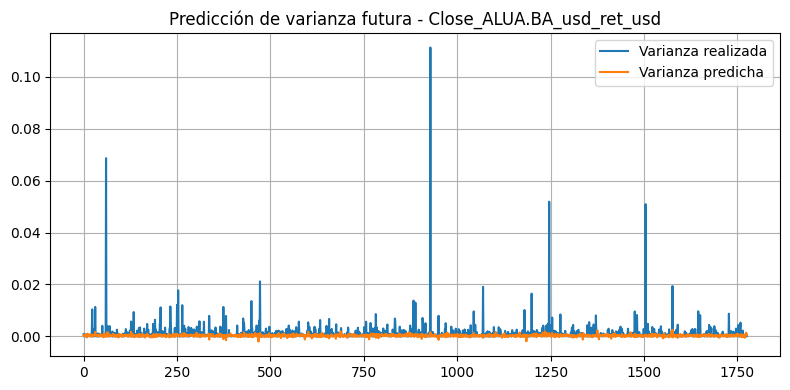


📈 Métricas para Close_ALUA.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00107
MSE (Error Cuadrático Medio): 0.00002

📊 Entrenando LSTM para: Close_BBAR.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00003
Epoch 2/50 - Loss: 0.00000
Epoch 3/50 - Loss: 0.00001
Epoch 4/50 - Loss: 0.00001
Epoch 5/50 - Loss: 0.00002
Epoch 6/50 - Loss: 0.00002
Epoch 7/50 - Loss: 0.00004
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00001
Epoch 10/50 - Loss: 0.00003
Epoch 11/50 - Loss: 0.00001
Epoch 12/50 - Loss: 0.00001
Epoch 13/50 - Loss: 0.00001
Epoch 14/50 - Loss: 0.00000
Epoch 15/50 - Loss: 0.00001
Epoch 16/50 - Loss: 0.00000
Epoch 17/50 - Loss: 0.00001
Epoch 18/50 - Loss: 0.00002
Epoch 19/50 - Loss: 0.00002
Epoch 20/50 - Loss: 0.00001
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00001
Epoch 24/50 - Loss: 0.00001
Epoch 25/50 - Loss: 0.00002
Epoch 26/50 - Loss: 0.00001
Epoch 27/50 - Loss: 0.00005
Epoch 28/50 - Loss: 0.00003
Epoch 29/50 - Loss: 0.00001
Epoch 30/50 - Loss: 0.00000


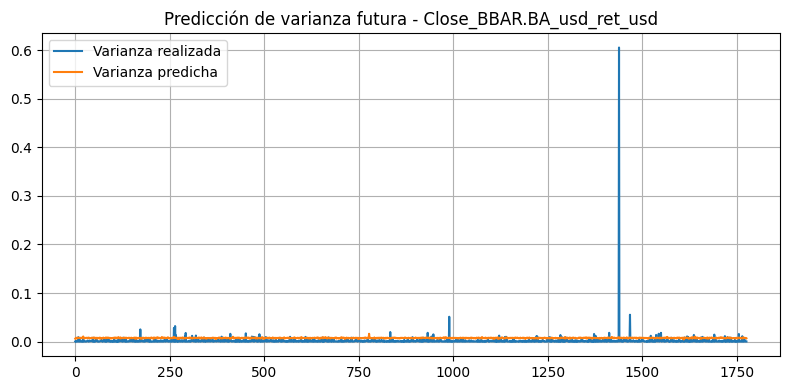


📈 Métricas para Close_BBAR.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00659
MSE (Error Cuadrático Medio): 0.00024

📊 Entrenando LSTM para: Close_BMA.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00006
Epoch 2/50 - Loss: 0.00003
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00002
Epoch 5/50 - Loss: 0.00002
Epoch 6/50 - Loss: 0.00002
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00002
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00004
Epoch 12/50 - Loss: 0.00001
Epoch 13/50 - Loss: 0.00001
Epoch 14/50 - Loss: 0.00006
Epoch 15/50 - Loss: 0.00001
Epoch 16/50 - Loss: 0.00001
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00002
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00001
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00006
Epoch 23/50 - Loss: 0.00001
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00001
Epoch 26/50 - Loss: 0.00001
Epoch 27/50 - Loss: 0.00001
Epoch 28/50 - Loss: 0.00001
Epoch 29/50 - Loss: 0.00001
Epoch 30/50 - Loss: 0.00000
E

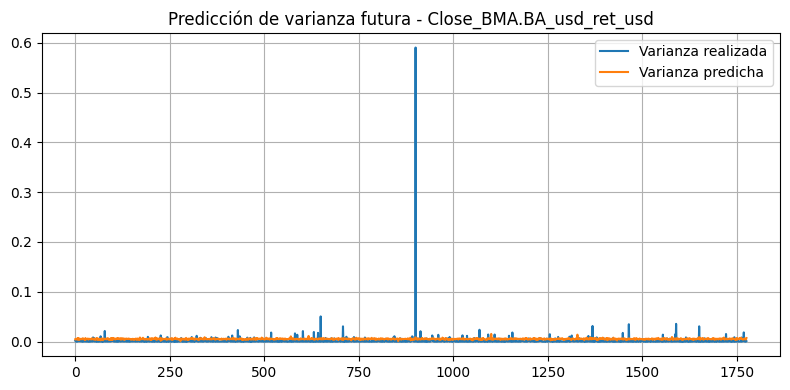


📈 Métricas para Close_BMA.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00477
MSE (Error Cuadrático Medio): 0.00022

📊 Entrenando LSTM para: Close_BYMA.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00000
Epoch 2/50 - Loss: 0.00003
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00031
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00001
Epoch 9/50 - Loss: 0.00001
Epoch 10/50 - Loss: 0.00001
Epoch 11/50 - Loss: 0.00000
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00000
Epoch 15/50 - Loss: 0.00001
Epoch 16/50 - Loss: 0.00002
Epoch 17/50 - Loss: 0.00002
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00000
Epoch 21/50 - Loss: 0.00001
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00001
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00000
Epoch 29/50 - Loss: 0.00000
Epoch 30/50 - Loss: 0.00000
E

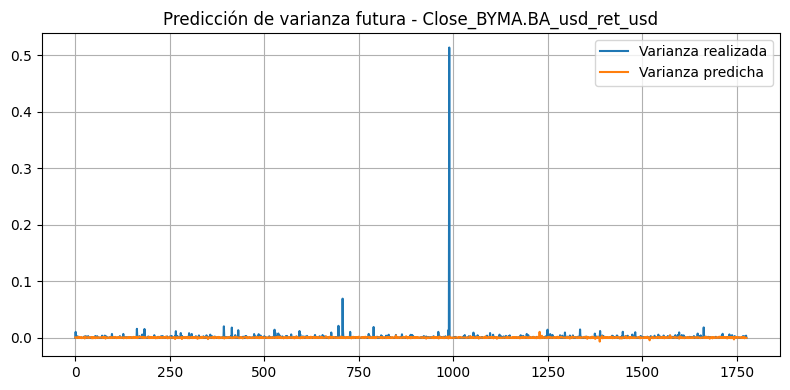


📈 Métricas para Close_BYMA.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00146
MSE (Error Cuadrático Medio): 0.00015

📊 Entrenando LSTM para: Close_CEPU.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00001
Epoch 2/50 - Loss: 0.00005
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00001
Epoch 7/50 - Loss: 0.00001
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00002
Epoch 10/50 - Loss: 0.00002
Epoch 11/50 - Loss: 0.00001
Epoch 12/50 - Loss: 0.00001
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00003
Epoch 15/50 - Loss: 0.00001
Epoch 16/50 - Loss: 0.00000
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00000
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00003
Epoch 26/50 - Loss: 0.00005
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00000
Epoch 29/50 - Loss: 0.00001
Epoch 30/50 - Loss: 0.00002


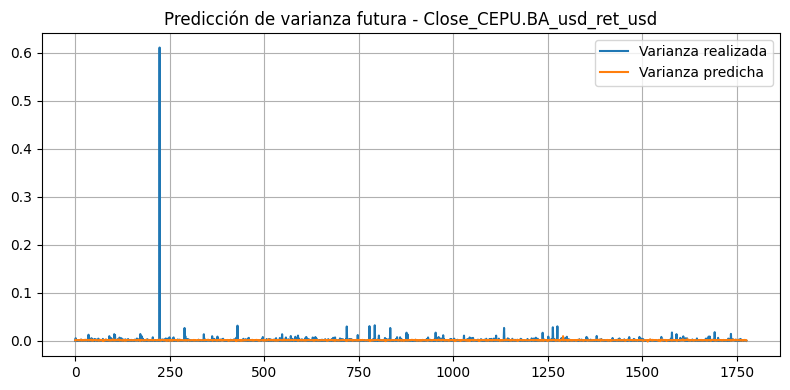


📈 Métricas para Close_CEPU.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00189
MSE (Error Cuadrático Medio): 0.00022

📊 Entrenando LSTM para: Close_COME.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00002
Epoch 2/50 - Loss: 0.00000
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00305
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00001
Epoch 8/50 - Loss: 0.00003
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00000
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00000
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00001
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00000
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00004
Epoch 26/50 - Loss: 0.00000
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00001
Epoch 29/50 - Loss: 0.00010
Epoch 30/50 - Loss: 0.00001


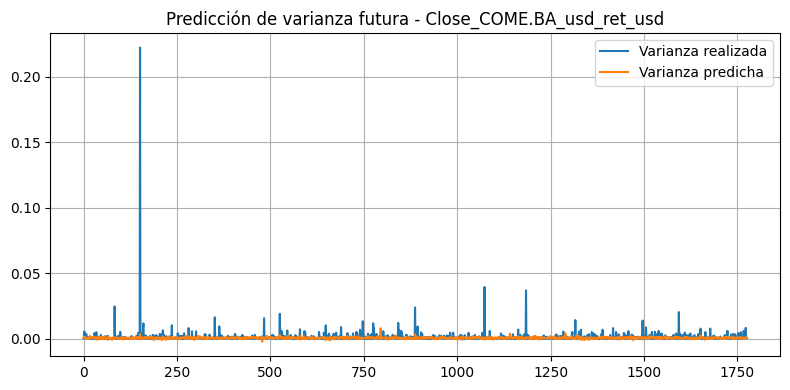


📈 Métricas para Close_COME.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00118
MSE (Error Cuadrático Medio): 0.00003

📊 Entrenando LSTM para: Close_CRES.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00000
Epoch 2/50 - Loss: 0.00001
Epoch 3/50 - Loss: 0.00198
Epoch 4/50 - Loss: 0.00001
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00020
Epoch 11/50 - Loss: 0.00000
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00001
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00001
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00011
Epoch 21/50 - Loss: 0.00001
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00000
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00000
Epoch 29/50 - Loss: 0.00000
Epoch 30/50 - Loss: 0.00000


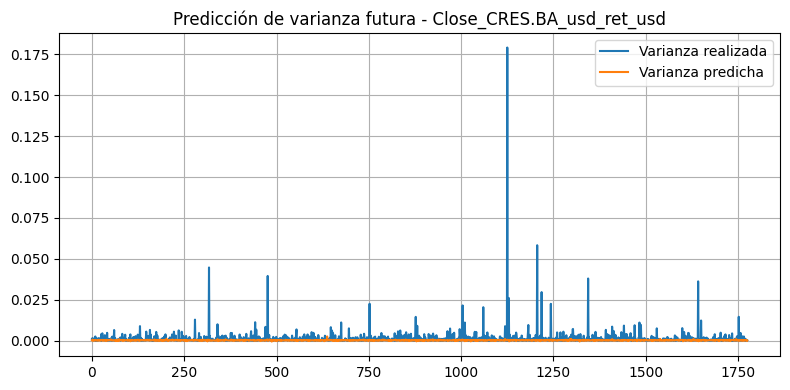


📈 Métricas para Close_CRES.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00122
MSE (Error Cuadrático Medio): 0.00003

📊 Entrenando LSTM para: Close_EDN.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00000
Epoch 2/50 - Loss: 0.00000
Epoch 3/50 - Loss: 0.00001
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00001
Epoch 6/50 - Loss: 0.00003
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00003
Epoch 9/50 - Loss: 0.00001
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00002
Epoch 12/50 - Loss: 0.00006
Epoch 13/50 - Loss: 0.00001
Epoch 14/50 - Loss: 0.00004
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00000
Epoch 17/50 - Loss: 0.00003
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00002
Epoch 21/50 - Loss: 0.00005
Epoch 22/50 - Loss: 0.00001
Epoch 23/50 - Loss: 0.00002
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00001
Epoch 26/50 - Loss: 0.00000
Epoch 27/50 - Loss: 0.00001
Epoch 28/50 - Loss: 0.00002
Epoch 29/50 - Loss: 0.00003
Epoch 30/50 - Loss: 0.00001
E

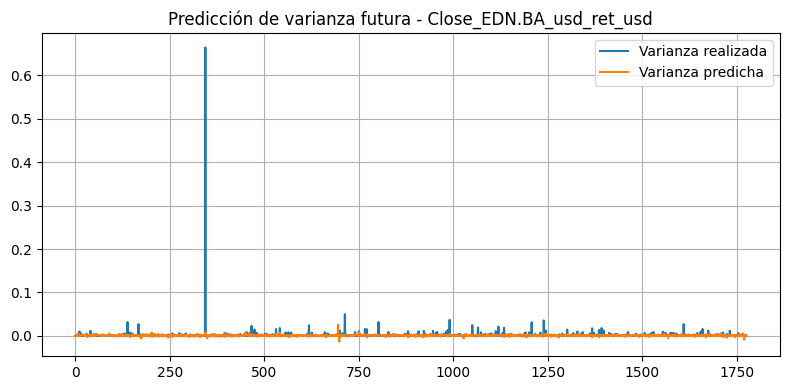


📈 Métricas para Close_EDN.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00219
MSE (Error Cuadrático Medio): 0.00026

📊 Entrenando LSTM para: Close_GGAL.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00000
Epoch 2/50 - Loss: 0.00001
Epoch 3/50 - Loss: 0.00001
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00002
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00001
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00008
Epoch 10/50 - Loss: 0.00002
Epoch 11/50 - Loss: 0.00005
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00001
Epoch 15/50 - Loss: 0.00002
Epoch 16/50 - Loss: 0.00000
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00001
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00003
Epoch 21/50 - Loss: 0.00001
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00011
Epoch 24/50 - Loss: 0.02280
Epoch 25/50 - Loss: 0.00009
Epoch 26/50 - Loss: 0.00000
Epoch 27/50 - Loss: 0.00001
Epoch 28/50 - Loss: 0.00007
Epoch 29/50 - Loss: 0.00003
Epoch 30/50 - Loss: 0.00001
E

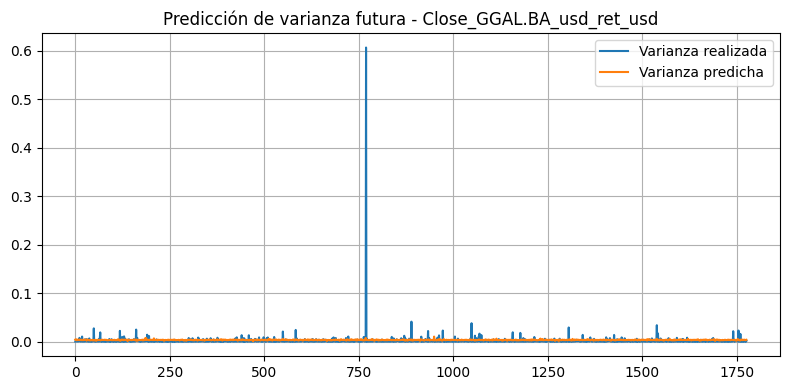


📈 Métricas para Close_GGAL.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00321
MSE (Error Cuadrático Medio): 0.00022

📊 Entrenando LSTM para: Close_IRSA.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00000
Epoch 2/50 - Loss: 0.00000
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00002
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00001
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00001
Epoch 14/50 - Loss: 0.00001
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00001
Epoch 17/50 - Loss: 0.00001
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00000
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00224
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00000
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00000
Epoch 29/50 - Loss: 0.00000
Epoch 30/50 - Loss: 0.00000


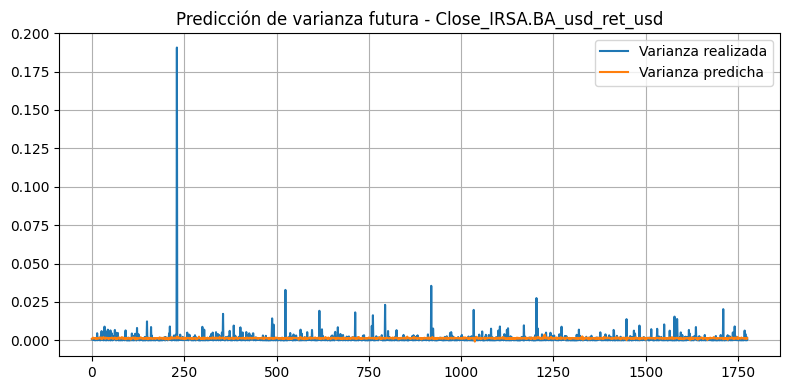


📈 Métricas para Close_IRSA.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00147
MSE (Error Cuadrático Medio): 0.00003

📊 Entrenando LSTM para: Close_LOMA.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00002
Epoch 2/50 - Loss: 0.00001
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00001
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00001
Epoch 8/50 - Loss: 0.00001
Epoch 9/50 - Loss: 0.00005
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00000
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00001
Epoch 14/50 - Loss: 0.00001
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00003
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00004
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00001
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00001
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00002
Epoch 27/50 - Loss: 0.00002
Epoch 28/50 - Loss: 0.00002
Epoch 29/50 - Loss: 0.00000
Epoch 30/50 - Loss: 0.00002


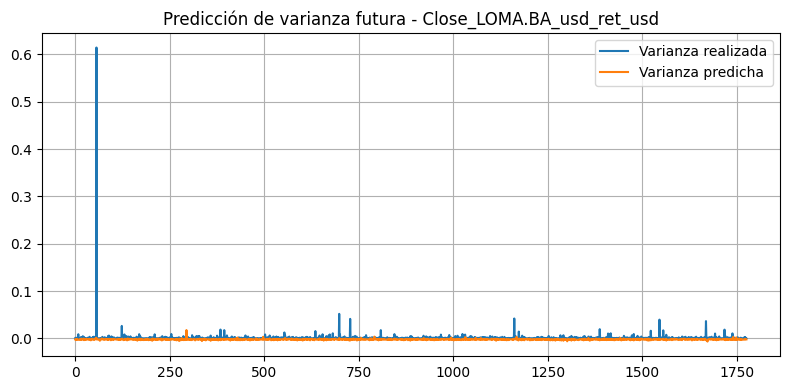


📈 Métricas para Close_LOMA.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00374
MSE (Error Cuadrático Medio): 0.00023

📊 Entrenando LSTM para: Close_METR.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00002
Epoch 2/50 - Loss: 0.00014
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00002
Epoch 7/50 - Loss: 0.00002
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00001
Epoch 11/50 - Loss: 0.00002
Epoch 12/50 - Loss: 0.00003
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00001
Epoch 15/50 - Loss: 0.00001
Epoch 16/50 - Loss: 0.00003
Epoch 17/50 - Loss: 0.00001
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00002
Epoch 21/50 - Loss: 0.00003
Epoch 22/50 - Loss: 0.00024
Epoch 23/50 - Loss: 0.00001
Epoch 24/50 - Loss: 0.00001
Epoch 25/50 - Loss: 0.00001
Epoch 26/50 - Loss: 0.00001
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00001
Epoch 29/50 - Loss: 0.00003
Epoch 30/50 - Loss: 0.00003


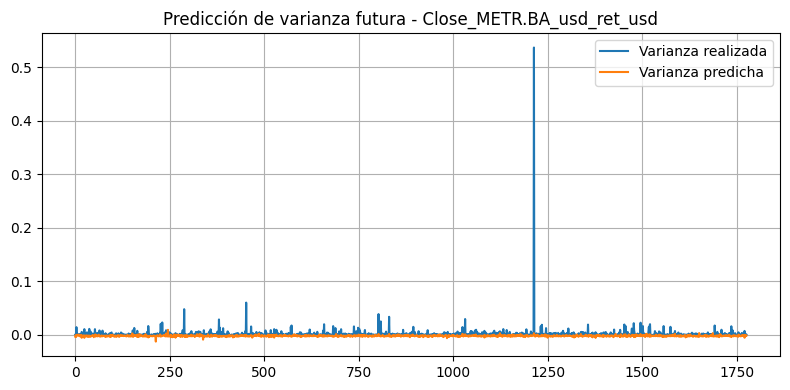


📈 Métricas para Close_METR.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00367
MSE (Error Cuadrático Medio): 0.00019

📊 Entrenando LSTM para: Close_PAMP.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00001
Epoch 2/50 - Loss: 0.00000
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00001
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00003
Epoch 12/50 - Loss: 0.00002
Epoch 13/50 - Loss: 0.00001
Epoch 14/50 - Loss: 0.00001
Epoch 15/50 - Loss: 0.00001
Epoch 16/50 - Loss: 0.01846
Epoch 17/50 - Loss: 0.00001
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00001
Epoch 21/50 - Loss: 0.00001
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00001
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00001
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00000
Epoch 29/50 - Loss: 0.00001
Epoch 30/50 - Loss: 0.00000


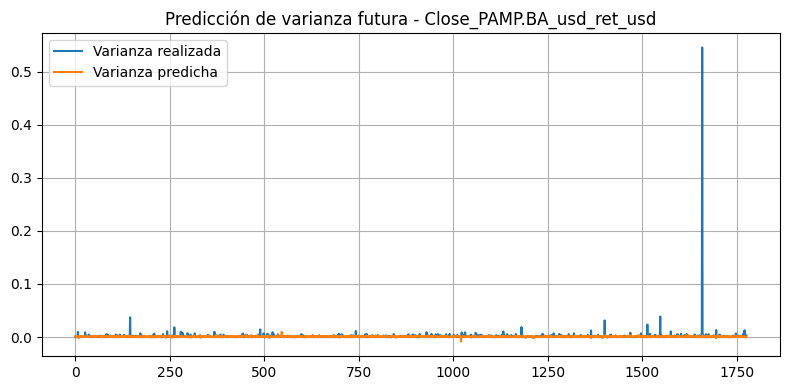


📈 Métricas para Close_PAMP.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00160
MSE (Error Cuadrático Medio): 0.00017

📊 Entrenando LSTM para: Close_SUPV.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00002
Epoch 2/50 - Loss: 0.00002
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00004
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00003
Epoch 7/50 - Loss: 0.00002
Epoch 8/50 - Loss: 0.00001
Epoch 9/50 - Loss: 0.00001
Epoch 10/50 - Loss: 0.00001
Epoch 11/50 - Loss: 0.00001
Epoch 12/50 - Loss: 0.00001
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00002
Epoch 15/50 - Loss: 0.00003
Epoch 16/50 - Loss: 0.00001
Epoch 17/50 - Loss: 0.00001
Epoch 18/50 - Loss: 0.00003
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00003
Epoch 21/50 - Loss: 0.00024
Epoch 22/50 - Loss: 0.00002
Epoch 23/50 - Loss: 0.00001
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00001
Epoch 26/50 - Loss: 0.00002
Epoch 27/50 - Loss: 0.00001
Epoch 28/50 - Loss: 0.00005
Epoch 29/50 - Loss: 0.00003
Epoch 30/50 - Loss: 0.00000


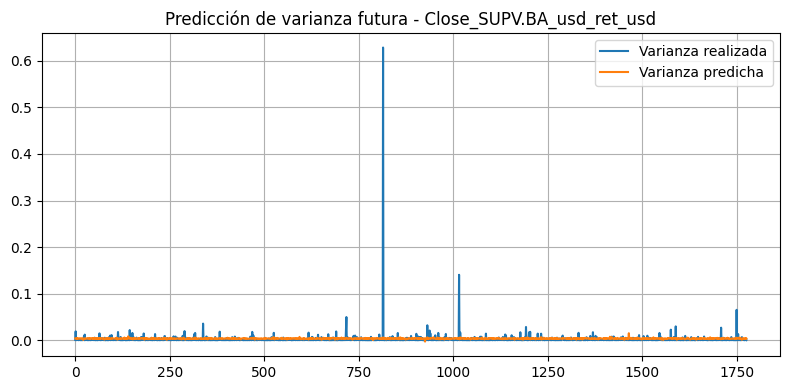


📈 Métricas para Close_SUPV.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00355
MSE (Error Cuadrático Medio): 0.00025

📊 Entrenando LSTM para: Close_TECO2.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00000
Epoch 2/50 - Loss: 0.00001
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00003
Epoch 6/50 - Loss: 0.00005
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00001
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00000
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00000
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00001
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00001
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00000
Epoch 27/50 - Loss: 0.00003
Epoch 28/50 - Loss: 0.00000
Epoch 29/50 - Loss: 0.00001
Epoch 30/50 - Loss: 0.00000

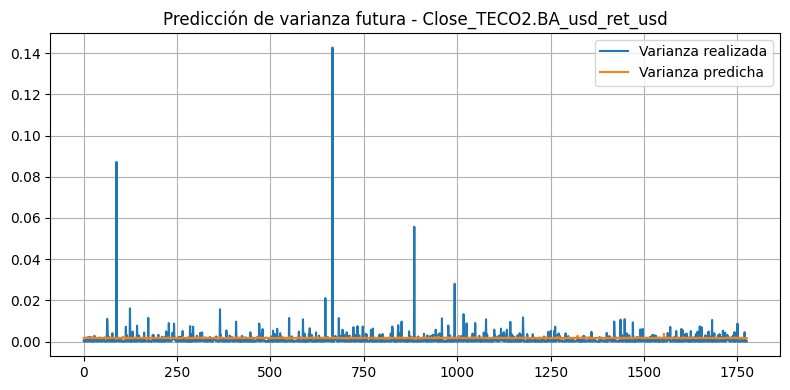


📈 Métricas para Close_TECO2.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00169
MSE (Error Cuadrático Medio): 0.00002

📊 Entrenando LSTM para: Close_TGNO4.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00003
Epoch 2/50 - Loss: 0.00001
Epoch 3/50 - Loss: 0.00002
Epoch 4/50 - Loss: 0.00000
Epoch 5/50 - Loss: 0.00001
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00002
Epoch 8/50 - Loss: 0.00001
Epoch 9/50 - Loss: 0.00001
Epoch 10/50 - Loss: 0.00001
Epoch 11/50 - Loss: 0.00000
Epoch 12/50 - Loss: 0.00001
Epoch 13/50 - Loss: 0.00003
Epoch 14/50 - Loss: 0.00001
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00001
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00000
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00001
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00001
Epoch 27/50 - Loss: 0.00002
Epoch 28/50 - Loss: 0.00001
Epoch 29/50 - Loss: 0.00000
Epoch 30/50 - Loss: 0.0000

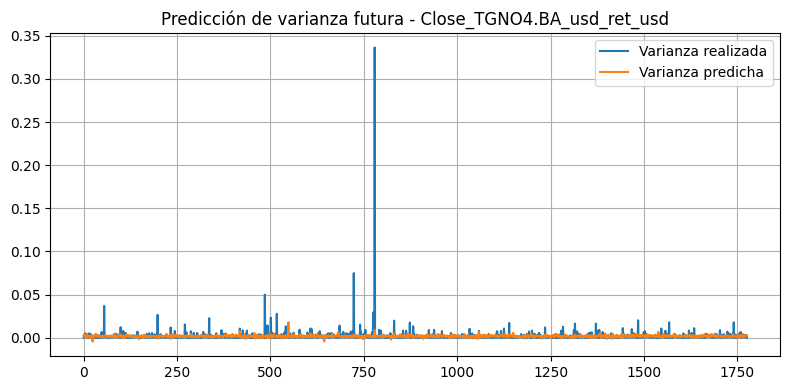


📈 Métricas para Close_TGNO4.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00208
MSE (Error Cuadrático Medio): 0.00007

📊 Entrenando LSTM para: Close_TGSU2.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00000
Epoch 2/50 - Loss: 0.00000
Epoch 3/50 - Loss: 0.00002
Epoch 4/50 - Loss: 0.00002
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00001
Epoch 11/50 - Loss: 0.00000
Epoch 12/50 - Loss: 0.00001
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00000
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00000
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00000
Epoch 21/50 - Loss: 0.00002
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00001
Epoch 26/50 - Loss: 0.00001
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00000
Epoch 29/50 - Loss: 0.00000
Epoch 30/50 - Loss: 0.0000

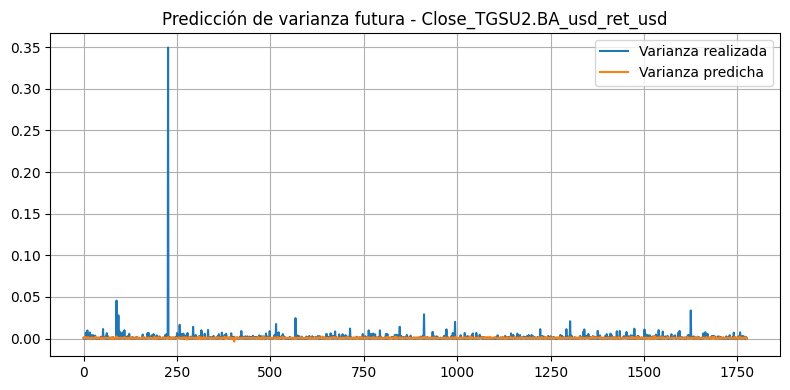


📈 Métricas para Close_TGSU2.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00138
MSE (Error Cuadrático Medio): 0.00008

📊 Entrenando LSTM para: Close_TRAN.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00005
Epoch 2/50 - Loss: 0.00002
Epoch 3/50 - Loss: 0.00002
Epoch 4/50 - Loss: 0.00002
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00007
Epoch 7/50 - Loss: 0.00003
Epoch 8/50 - Loss: 0.00001
Epoch 9/50 - Loss: 0.00003
Epoch 10/50 - Loss: 0.00001
Epoch 11/50 - Loss: 0.00002
Epoch 12/50 - Loss: 0.00001
Epoch 13/50 - Loss: 0.00001
Epoch 14/50 - Loss: 0.00001
Epoch 15/50 - Loss: 0.00001
Epoch 16/50 - Loss: 0.00000
Epoch 17/50 - Loss: 0.00001
Epoch 18/50 - Loss: 0.00001
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00001
Epoch 21/50 - Loss: 0.00001
Epoch 22/50 - Loss: 0.00001
Epoch 23/50 - Loss: 0.00001
Epoch 24/50 - Loss: 0.00035
Epoch 25/50 - Loss: 0.00001
Epoch 26/50 - Loss: 0.00001
Epoch 27/50 - Loss: 0.00001
Epoch 28/50 - Loss: 0.00001
Epoch 29/50 - Loss: 0.00000
Epoch 30/50 - Loss: 0.00000

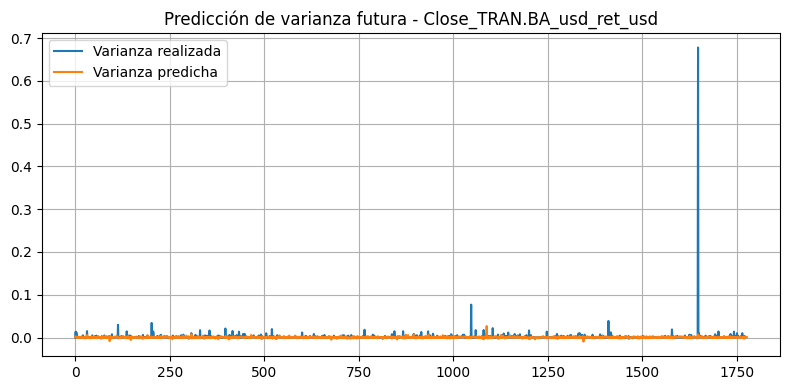


📈 Métricas para Close_TRAN.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00212
MSE (Error Cuadrático Medio): 0.00027

📊 Entrenando LSTM para: Close_TXAR.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00003
Epoch 2/50 - Loss: 0.00000
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00002
Epoch 5/50 - Loss: 0.00003
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00001
Epoch 8/50 - Loss: 0.00001
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00000
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00000
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00000
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00005
Epoch 19/50 - Loss: 0.00001
Epoch 20/50 - Loss: 0.00203
Epoch 21/50 - Loss: 0.00003
Epoch 22/50 - Loss: 0.00000
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00000
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00000
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00001
Epoch 29/50 - Loss: 0.00000
Epoch 30/50 - Loss: 0.00000


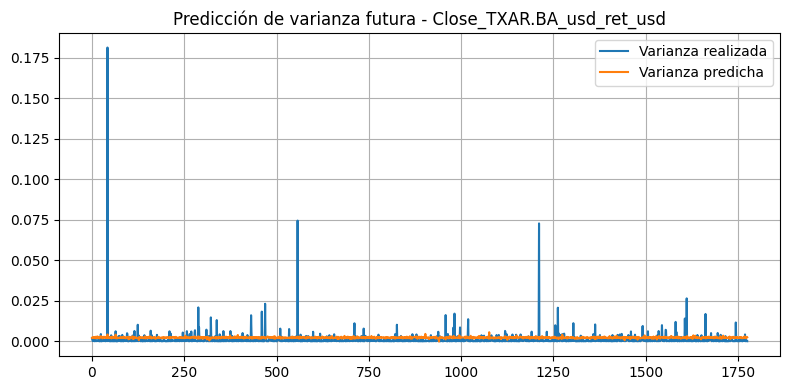


📈 Métricas para Close_TXAR.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00210
MSE (Error Cuadrático Medio): 0.00003

📊 Entrenando LSTM para: Close_VALO.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00001
Epoch 2/50 - Loss: 0.00000
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00002
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00000
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00004
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00001
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00000
Epoch 14/50 - Loss: 0.00000
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00001
Epoch 17/50 - Loss: 0.00000
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00000
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00001
Epoch 23/50 - Loss: 0.00001
Epoch 24/50 - Loss: 0.00001
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00001
Epoch 27/50 - Loss: 0.00000
Epoch 28/50 - Loss: 0.00001
Epoch 29/50 - Loss: 0.00001
Epoch 30/50 - Loss: 0.00000


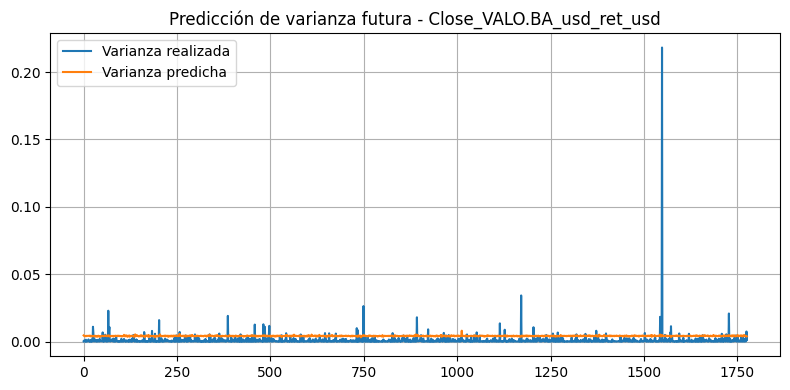


📈 Métricas para Close_VALO.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00378
MSE (Error Cuadrático Medio): 0.00004

📊 Entrenando LSTM para: Close_YPFD.BA_usd_ret_usd
Epoch 1/50 - Loss: 0.00000
Epoch 2/50 - Loss: 0.00040
Epoch 3/50 - Loss: 0.00000
Epoch 4/50 - Loss: 0.00010
Epoch 5/50 - Loss: 0.00000
Epoch 6/50 - Loss: 0.00001
Epoch 7/50 - Loss: 0.00000
Epoch 8/50 - Loss: 0.00000
Epoch 9/50 - Loss: 0.00000
Epoch 10/50 - Loss: 0.00000
Epoch 11/50 - Loss: 0.00001
Epoch 12/50 - Loss: 0.00000
Epoch 13/50 - Loss: 0.00071
Epoch 14/50 - Loss: 0.00000
Epoch 15/50 - Loss: 0.00000
Epoch 16/50 - Loss: 0.00000
Epoch 17/50 - Loss: 0.00003
Epoch 18/50 - Loss: 0.00000
Epoch 19/50 - Loss: 0.00000
Epoch 20/50 - Loss: 0.00056
Epoch 21/50 - Loss: 0.00000
Epoch 22/50 - Loss: 0.00001
Epoch 23/50 - Loss: 0.00000
Epoch 24/50 - Loss: 0.00002
Epoch 25/50 - Loss: 0.00000
Epoch 26/50 - Loss: 0.00000
Epoch 27/50 - Loss: 0.00001
Epoch 28/50 - Loss: 0.00001
Epoch 29/50 - Loss: 0.00000
Epoch 30/50 - Loss: 0.00000


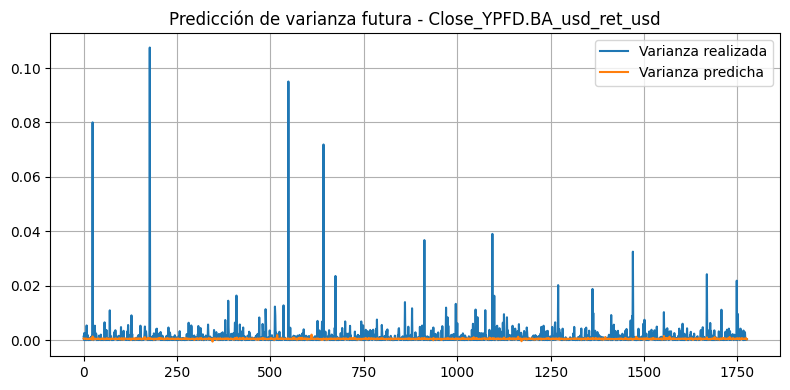


📈 Métricas para Close_YPFD.BA_usd_ret_usd:
MAE (Error Absoluto Medio): 0.00125
MSE (Error Cuadrático Medio): 0.00002


In [ ]:
# Entreno y visualizo ajuste
for col in df_filtrado.columns:
    print(f"\n📊 Entrenando LSTM para: {col}")
    entrenar_modelo_lstm(df, col)